<a href="https://colab.research.google.com/github/sayan0506/Siamese-Network-Implementation-On-MNIST-Data-Using-Keras-/blob/master/Create_a_Saimese_Network_with_Triplet_Loss_in_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Siamese Network with Triplet Loss implementation using Keras on MNIST Dataset

#Importing necessary python **modules**

In [163]:
# Installing livelossplot module for dynamical plot of model training
!pip install git+git://github.com/stared/livelossplot.git

  Cloning git://github.com/stared/livelossplot.git to /tmp/pip-req-build-03bmnnn3
  Running command git clone -q git://github.com/stared/livelossplot.git /tmp/pip-req-build-03bmnnn3
  Created wheel for livelossplot: filename=livelossplot-0.5.3-cp36-none-any.whl size=22611 sha256=a39047bc6bccbb04c082b374daeac54f8d94122de019a26e55ba89c6e161b9b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-s9y6biv9/wheels/77/01/ea/cef3581d9c77ece0fd685cc3eb1cd92dc68d8117b361ac65dc
Successfully built livelossplot


In [164]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import random
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam
from livelossplot.tf_keras import  PlotLossesCallback

print('Tensorflow version: ',tf.version.VERSION)

Tensorflow version:  2.3.0


# Siamese Network Approach

The concept of **Siamese Network** and backpropagation using **Triplet Loss** approach was taken from **FaceNet Paper**, where it was immensely used for embedding of faces, where each face of the persons were pass through the model which gives 128 dimensional embedding array or an array of **128** values, which in turn compared with positive and negative image to calculate triplet losses and train the network model.

Let's go through the approaches stepwise with example:

* First we have a Convolutional Neural Network(CNN) Model

* Corresponding to each example there are three examples:

 1. person1_image1.jpg(Anchor example)
 2. person1_image2.jpg(Positive example)
 3. person2_image3.jpg(Negative example)

 ## **Siamese Network**

 * All the three images are passed through the model and we get three embedding for the three images(Anchor, Positive, Negative) corresponding to each example.
 * The three instances of the EmbedddingModel from the three images are shared instances of same model, i.e parameters are shared and are updated for the three paths simultaneously.








# Loading Dataset

For this Siamese network training we are using Mnist dataset of Keras.

In [165]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('Dataset shape \nTrain input: {0}\nTrain output: {1}\nTest input: {2}\nTest output: {3}\n'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

Dataset shape 
Train input: (60000, 28, 28)
Train output: (60000,)
Test input: (10000, 28, 28)
Test output: (10000,)



# Data Visualization

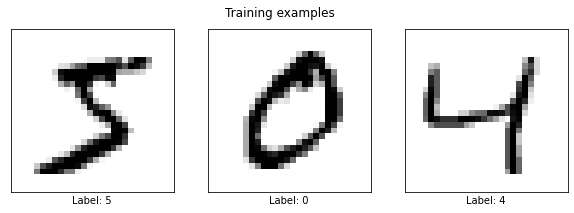

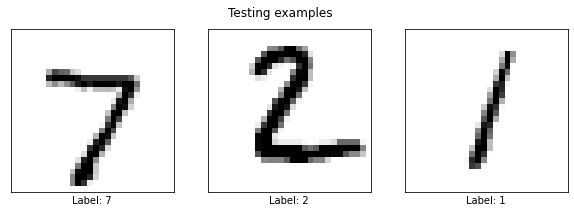

In [166]:
# plotting example images before creating batched of triplets

def plot_example(x, y, suptitle):
  fig = plt.figure(figsize = (10,3))
  fig.suptitle(suptitle)
  for i in range(3):
    plt.subplot(1, 3, i+1)
    # gray scale means max pixel val = 128
    # bnary means, pixel>threshold = 1, else 0
    plt.imshow(np.squeeze(x[i]), cmap = 'binary')
    plt.xticks([])             
    plt.yticks([])
    plt.xlabel('Label: {0}'.format(y[i]))

plot_example(x_train, y_train, 'Training examples')
plot_example(x_test, y_test, 'Testing examples')

In [167]:
# reshaping the inputs

x_train = x_train.reshape(x_train.shape[0], 784)/256
x_test = x_test.reshape(x_test.shape[0], 784)/256
print('After reshaping:\n{0}\n{1}'.format(x_train.shape, x_test.shape))

After reshaping:
(60000, 784)
(10000, 784)


# Creating Triplet Batches

In [168]:
def create_batch(batch_size = 256):
  # initializing the matrices
  # passing shapes as tuples
  x_anchors = np.zeros((batch_size, 784))
  x_positives = np.zeros((batch_size, 784))
  x_negatives = np.zeros((batch_size, 784))

  for i in range(batch_size):
    # we need to find triplets
    index_anchor = random.randint(0, x_train.shape[0]-1)
    x_anchors[i] = x_train[index_anchor]

    # fetching positive indices
    indices_positive = np.squeeze(np.where(y_train == y_train[index_anchor]))
    # fetching negative indices
    indices_negative = np.squeeze(np.where(y_train != y_train[index_anchor]))

    x_positives[i] = x_train[indices_positive[random.randint(0,len(indices_positive)-1)]]
    x_negatives[i] = x_train[indices_negative[random.randint(0,len(indices_negative)-1)]]

  # here three ndarrays(3, 784) are concatenated in a list
  # say, for 4 batches, length of list will remain 3, as length of each anchors, positive, negative array changes with batch size
  # but list elements remain 3
  # shape of concatenated lis = (3, batch_size, 784) 
  return [x_anchors, x_positives, x_negatives]  

## Sample Triplets Visualization

Triplet batches visualization


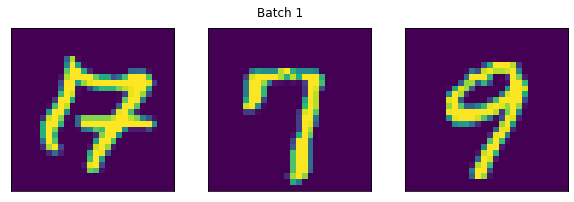

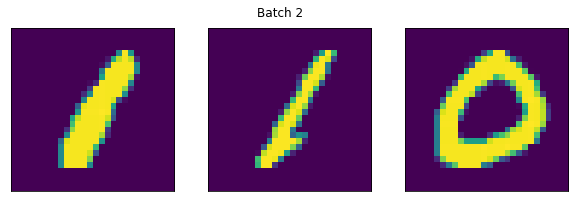

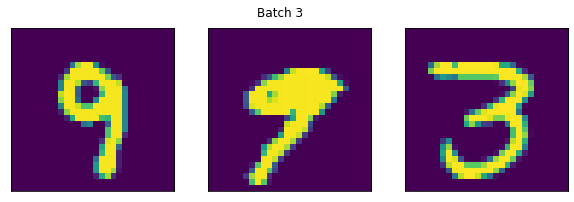

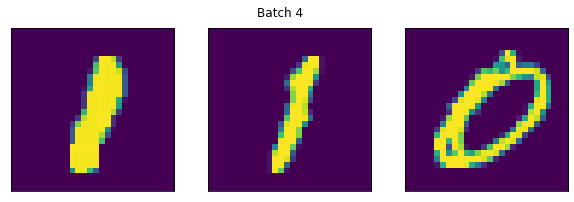

In [169]:
# creating 3 batches of triplets
no_batches = 4
example = create_batch(no_batches)
print('Triplet batches visualization')
for i in range(no_batches):
  fig = plt.figure(figsize=(10,3))
  fig.suptitle('Batch '+str(i+1))
  for j in range(3):
    plt.subplot(1,3, j+1)
    plt.imshow(example[j][i].reshape(28,28))
    plt.xticks([])
    plt.yticks([])



# Embedding Model

Embedding Model Summary

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
Total params: 54,400
Trainable params: 54,400
Non-trainable params: 0
_________________________________________________________________


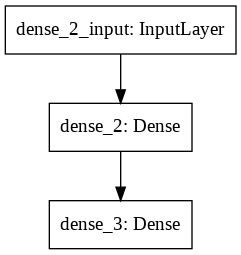

In [170]:
# let us consider embedding size = 64

embed_size = 64

embedding_model = tf.keras.models.Sequential([tf.keras.layers.Dense(64, activation='relu', input_shape = (784,)),
                                              tf.keras.layers.Dense(embed_size, activation='sigmoid')])

print('Embedding Model Summary\n')
embedding_model.summary()
plot_model(embedding_model)

# Siamese Network

Siamese Network Summary

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           54400       input_7[0][0]                    
                                                              

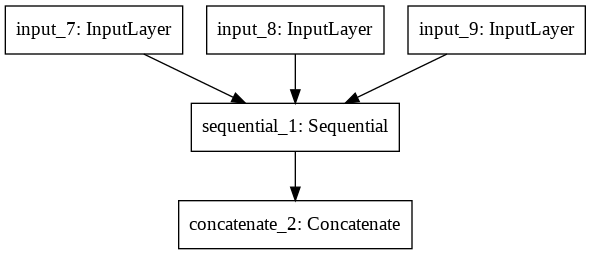

In [233]:
input_anchor = tf.keras.layers.Input(shape=(784,))
input_positive = tf.keras.layers.Input(shape=(784,))
input_negative = tf.keras.layers.Input(shape=(784,))

# the model object can take input layer argument
embedding_anchor = embedding_model(input_anchor)
embedding_positive = embedding_model(input_positive)
embedding_negative = embedding_model(input_negative)

output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, embedding_negative], axis = 1)

net = tf.keras.models.Model([input_anchor, input_positive, input_negative], output)

print('Siamese Network Summary\n')
net.summary()
plot_model(net)

# Triplet Loss

A loss function that tries to pull the Embeddings of Anchor and Positive Examples closer, and tries to push the Embeddings of Anchor and Negative Examples away from each other.

Root mean square difference between Anchor and Positive examples in a batch of N images is:
$
\begin{equation}
d_p = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(p_i))^2}{N}}
\end{equation}
$

Root mean square difference between Anchor and Negative examples in a batch of N images is:
$
\begin{equation}
d_n = \sqrt{\frac{\sum_{i=0}^{N-1}(f(a_i) - f(n_i))^2}{N}}
\end{equation}
$

For each example, we want:
$
\begin{equation}
d_p \leq d_n
\end{equation}
$

Therefore,
$
\begin{equation}
d_p - d_n \leq 0
\end{equation}
$

This condition is quite easily satisfied during the training.

We will make it non-trivial by adding a margin (alpha):
$
\begin{equation}
d_p - d_n + \alpha \leq 0
\end{equation}
$

Given the condition above, the Triplet Loss L is defined as:
$
\begin{equation}
L = max(d_p - d_n + \alpha, 0)
\end{equation}
$

In [172]:
# choosing the margin hyperparameter to be 0.2
alpha = 0.2

def triplet_loss(y_true, y_pred):
  anchor, positive, negative = y_pred[:,:embed_size],y_pred[:,embed_size:2*embed_size],y_pred[:,2*embed_size:]
  positive_dist = tf.reduce_mean(tf.square(tf.subtract(anchor, positive)), axis = 1)
  negative_dist = tf.reduce_mean(tf.square(tf.subtract(anchor, negative)), axis = 1)
  diff = tf.subtract(positive_dist, negative_dist)
  loss = tf.maximum(diff + alpha, 0)

  return loss

In [173]:
def data_generator(batch_size=256):
    while True:
        x = create_batch(batch_size)
        y = np.zeros((batch_size, 3*embed_size))
        yield x, y

# Model Training

Adam optimizer is used here

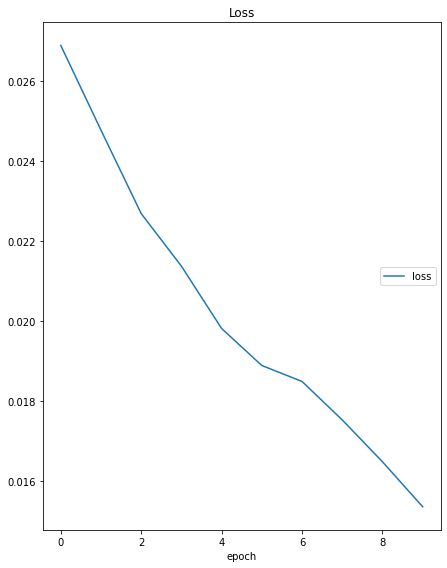

Loss
	loss             	 (min:    0.015, max:    0.027, cur:    0.015)
29/29 [==============================] - 26s 886ms/step - loss: 0.0154


In [193]:
net.compile(optimizer=Adam(lr=0.001), loss = triplet_loss)

batch_size = 2048
steps_per_epoch = int(x_train.shape[0]/batch_size)

history = net.fit(data_generator(batch_size=batch_size),
                  steps_per_epoch=steps_per_epoch,
                  epochs = 10,
                  verbose = 1,
                  callbacks = [PlotLossesCallback()]
                  )

**Note: When to use yield instead of return in Python?**

The yield statement suspends function’s execution and sends a value back to the caller, but retains enough state to enable function to resume where it is left off. When resumed, the function continues execution immediately after the last yield run. This allows its code to produce a series of values over time, rather than computing them at once and sending them back like a list.

Let’s see with an example:

filter_none
edit
play_arrow

brightness_4

'''
def simpleGeneratorFun(): 

    yield 1
    yield 2
    yield 3
'''  
for value in simpleGeneratorFun():  
    print(value) 
Output:

1
2
3
Return sends a specified value back to its caller whereas Yield can produce a sequence of values. We should use yield when we want to iterate over a sequence, but don’t want to store the entire sequence in memory.

Yield are used in Python generators. A generator function is defined like a normal function, but whenever it needs to generate a value, it does so with the yield keyword rather than return. If the body of a def contains yield, the function automatically becomes a generator function.



# Visualizing Result of The Trained Model



## Generating encoding database for digits recognition

In [194]:
# storing indices from test dataset
indices = np.zeros(10)

for i in range(10):
  indices[i] = np.squeeze(np.where(y_test == i))[0]

print('1st index of all types of digits in the test data are:\n',indices)

1st index of all types of digits in the test data are:
 [ 3.  2.  1. 18.  4.  8. 11.  0. 61.  7.]


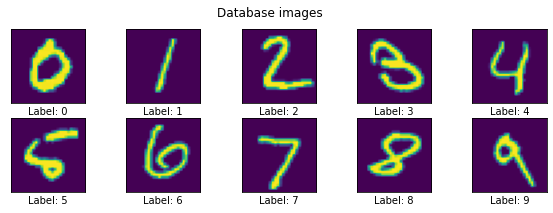

In [227]:
# Visualizing embedding database images
fig = plt.figure(figsize=(10,3))
fig.suptitle('Database images')
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(x_test[int(indices[i])].reshape(28,28))
  plt.xticks([])
  plt.yticks([])
  plt.xlabel('Label: {0}'.format(y_test[int(indices[i])]))
plt.show()

After training the weights of the embedding model are tuned to embed the input images

In [228]:
def embed_image(image):
  image = image.reshape(1,784)
  out = embedding_model.predict(image)
  return out

Storing the encoding of all types of digits in a dictionary

In [229]:
# Storing the encoding of all types of digits in a dictionary
database = {}
for i in range(10):
  database[i] = embed_image(x_test[int(indices[i])])

* We have encoded database of 10 different types of digits
* Let's pass random images of 10 digits and check whether they can recognize or not

* Choicing a random element from each individual digit indices list

In [211]:
# we have encoded database of 10 different types of digits
# let's pass random images of 10 digits and check whether they can recognize or not

# choicing a random element from each individual digit indices list
random_indices = [random.choice(np.squeeze(np.where(y_test == i))[1:]) for i in range(10)]

Storing the encoding of all types of random test digits in a dictionary

In [212]:
# Storing the encoding of all types of random test digits in a dictionary
test_database = {}
for i in range(10):
  test_database[i] = embed_image(x_test[int(random_indices[i])])

#### Digits Recognition

* For difference checking the final training loass 0.03 is taken as marginal value 
* Threshold value = 0.03

In [213]:
def recognizer(encoding, threshold):
  # for difference checking the final training loass 0.03 is taken as marginal value  
  diff_list = [tf.reduce_mean(tf.square(tf.subtract(database[i],encoding)), axis=1) for i in range(10)]
  # threshold value = 0.03/0.07
  if min(diff_list) < threshold:
    return diff_list.index(min(diff_list))
  else:
    return diff_list, diff_list.index(min(diff_list))

In [214]:
# prediction list
threshold = 0.03
pred_list1 = [recognizer(test_database[i], threshold) for i in range(10)]
pred_list1

[0,
 1,
 2,
 ([<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.40238762], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.457076], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.31113595], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.04109093], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6249939], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5180167], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5006275], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.36336797], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.29578912], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.44695807], dtype=float32)>],
  3),
 ([<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.29628304], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=arr



* At threshold = 0.07

In [215]:
# prediction list
threshold = 0.07
pred_list2 = [recognizer(test_database[i], threshold) for i in range(10)]
pred_list2

[0,
 1,
 2,
 3,
 4,
 ([<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.29583496], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.54459804], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5061765], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.19485517], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.46914962], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.27561665], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.37817702], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.58668214], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2140663], dtype=float32)>,
   <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.36266428], dtype=float32)>],
  3),
 6,
 7,
 8,
 9]

# Discussion on Threshold Value

* At threshold = 0.03 and 0.07, some of the results are not satisfying the threshold.
* But still if we consider the min value in the difference list, the result is correct.
* So, considering the min_val we are predicting the result, or we can increase the threshold too, but taking min_val also does justice for the problem.
* Redefining the recognizer function, which only returns the minimum defference.

In [216]:
# redefining the recognizer function, which only returns the minimum defference 
def recognizer_min(encoding):
  # for difference checking the final training loss 0.03 is taken as marginal value  
  diff_list = [tf.reduce_mean(tf.square(tf.subtract(database[i],encoding)), axis=1) for i in range(10)]
  return diff_list.index(min(diff_list))

In [230]:
pred_list_final = [recognizer_min(test_database[i]) for i in range(10)]

In [231]:
print(pred_list_final)

[0, 1, 2, 3, 4, 3, 6, 7, 8, 9]


* Among 10 digits, 9 are correctly predicted except 5 has not been correctly predicted.
* We need to do some pre-processing techniques or modification in the process for further increase the accuracy

In [232]:
print('Random indices ',random_indices)

Random indices  [1203, 4869, 5037, 9727, 2319, 2558, 7880, 4083, 7694, 8093]


#### Visualizing prediction result

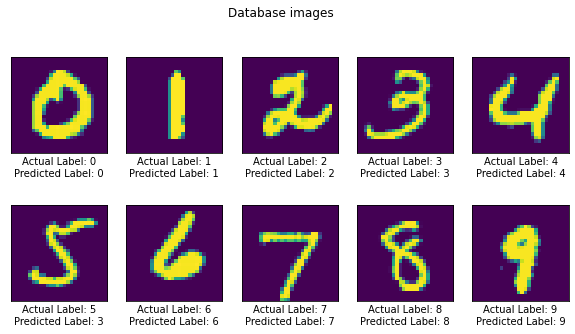

In [235]:
# Prediction result vis.
fig = plt.figure(figsize=(10,5))
fig.suptitle('Database images')
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(x_test[int(random_indices[i])].reshape(28,28))
  plt.xticks([])
  plt.yticks([])
  plt.xlabel('Actual Label: {0}\nPredicted Label: {1}'.format(y_test[int(random_indices[i])], pred_list_final[i]))
plt.show()

# Conclusion

The problem needs more modification, we can try several modifications and try several functional CNN for modiffying performances data pre-processing techniques or hyper-prameter tunings to increase the model accuracy.